In [1]:
import os
os.chdir("../")
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
import torch
from gpytorch.kernels import RBFKernel, ScaleKernel, PeriodicKernel, MaternKernel, CosineKernel
from skgpytorch.models import SVGPRegressor, SGPRegressor

In [3]:
import jax.numpy as jnp
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
# from utilities import plot
import tensorflow_probability.substrates.jax as tfp
dist = tfp.distributions
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from gpytorch.constraints import GreaterThan
from skgpytorch.metrics import mean_squared_error, negative_log_predictive_density
import time
import numpy as np

# from datasets.dataset_load import dataset_loader
from utilities import plot,fits,gmm,errors,predict,preprocess

# device = "cpu"
# torch.set_default_dtype(torch.float32)
# torch.set_default_tensor_type(torch.FloatTensor)


In [4]:
train ={1: {
          'start_time': "2011-04-28" ,
          'end_time': "2011-05-15"
        }, 
    3: {
          'start_time': "2011-04-19" ,
          'end_time': "2011-05-22"
    },
  
}
test = { 
    2: {
        'start_time': "2011-04-21" ,
        'end_time': "2011-05-21"
    }
 
}
appliances = ["Microwave"]


In [5]:
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler


def dataset_load(appliances, train, test=None):
    x_train = []
    y_train = []
    x_train_timestamp = []
    n = 9
    units_to_pad = n // 2
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    scaler_time = StandardScaler()
    # train
    for key, values in train.items():
        df = pd.read_csv(
            f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
        df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
        startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
        endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

        if startDate > endDate:
            raise "Start Date must be smaller than Enddate."

        df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
        df.dropna(inplace=True)
        x = df["main"].values
        y = df[appliances[0]].values
        timestamp_train = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values
        x = jnp.pad(x, (units_to_pad, units_to_pad),
                    'constant', constant_values=(0, 0))
        x = jnp.array([x[i: i + n] for i in range(len(x) - n + 1)])
        x_train.extend(x)
        y_train.extend(y)
        x_train_timestamp.extend(torch.tensor(timestamp_train))


    x_train = jnp.array(x_train)
    y_train = jnp.array(y_train).reshape(-1, 1)
    x_train_timestamp = torch.tensor(x_train_timestamp).reshape(-1,1)
    x_train = scaler_x.fit_transform(x_train)
    y_train = scaler_y.fit_transform(y_train)
    x_train_timestamp = scaler_time.fit_transform(x_train_timestamp)


    # test
    x_test = []
    y_test = []
    x_test_timestamp = []
    for key, values in test.items():
        df = pd.read_csv(
            f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
        df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
        startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
        endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

        if startDate > endDate:
            raise "Start Date must be smaller than Enddate."

        df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
        df.dropna(inplace=True)
        x = df["main"].values
        y = df[appliances[0]].values
        timestamp = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values
        x = jnp.pad(x, (units_to_pad, units_to_pad),
                    'constant', constant_values=(0, 0))
        x = jnp.array([x[i: i + n] for i in range(len(x) - n + 1)])
        x_test.extend(x)
        y_test.extend(y)
        x_test_timestamp.extend(timestamp)

    x_test = jnp.array(x_test)
    y_test = jnp.array(y_test).reshape(-1, 1)
    x_test_timestamp = torch.tensor(x_test_timestamp).reshape(-1,1)

    x_test = scaler_x.transform(x_test)
    x_test_timestamp = scaler_time.transform(x_test_timestamp)
#     y_test = scaler_y.transform(y_test)

    x_train = jnp.array(x_train).reshape(x_train.shape[0], n, 1)
    y_train = jnp.array(y_train)
    x_train_timestamp = torch.tensor(x_train_timestamp).reshape(x_train_timestamp.shape[0], 1)
    x_test = jnp.array(x_test).reshape(x_test.shape[0], n, 1)
    y_test = jnp.array(y_test)
    x_test_timestamp = torch.tensor(x_test_timestamp).reshape(x_test_timestamp.shape[0], 1).to(torch.float64)

    return x_train, y_train, x_test, y_test, x_train_timestamp, x_test_timestamp, scaler_x, scaler_y, scaler_time


In [6]:
x_train, y_train, x_test, y_test, x_train_timstamp, x_test_timestamp, scaler_x, scaler_y, scaler_time = dataset_load(appliances, train, test)

In [7]:
n = 9
# x_train_full = jnp.concatenate((x_train.reshape(-1,n), jnp.array(np.array(x_train_timstamp))), axis=1)
# x_test_full = jnp.concatenate((x_test.reshape(-1,n), jnp.array(np.array(x_test_timestamp))), axis=1)
# x_train_full.shape, x_test_full.shape

In [8]:
x_train.reshape(-1,n).shape, x_test.reshape(-1,n).shape, y_train.shape, y_test.shape

((24918, 9), (15656, 9), (24918, 1), (15656, 1))

In [9]:
x = torch.tensor(np.array(x_train).reshape(-1,n)).to(torch.float64)
y = torch.tensor(np.array(y_train)).reshape(-1,).to(torch.float64)
xt = torch.tensor(np.array(x_test).reshape(-1,n)).to(torch.float64)
yt = torch.tensor(np.array(y_test)).reshape(-1,).to(torch.float64)

In [10]:
x.shape, y.shape, xt.shape, yt.shape

(torch.Size([24918, 9]),
 torch.Size([24918]),
 torch.Size([15656, 9]),
 torch.Size([15656]))

In [11]:
mae_arr =[]
rms_arr = []
y_pred_arr = []

batch = 512

# x_train = x_train[:4500]
# y_train = y_train[:4500]

# y_test_trans = torch.tensor(torch.tensor(scaler_x.transform(y_test.reshape(-1,1))).reshape(-1,)).contiguous().to(torch.float64)
for i in range(1):


  kernel1 = ScaleKernel(RBFKernel(ard_num_dims=1,active_dims=(4))) #nu=2.5,
  # kernel2 = ScaleKernel(RBFKernel(ard_num_dims=n, active_dims=(6)))
  # kernel3 = ScaleKernel(PeriodicKernel(ard_num_dims=n, active_dims=(6)))
  kernel4 = ScaleKernel(RBFKernel(ard_num_dims=n))
  kernel5 = ScaleKernel(PeriodicKernel(ard_num_dims=1,active_dims=(4)))

  kernel = kernel4 # + kernel1*kernel5
  # induce_points = 512
  inducing_points =  x[np.arange(0,x.shape[0],20)] 
  # inducing_points = x[torch.randperm(x.shape[0])[: 1500]]
  
  model = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel,
                       inducing_points).to("cuda")
  # model.mll.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-2))
  # for param in model.parameters():
  #   # print(param)
  #   torch.nn.init.normal_(param, 0, 1)
  # theta1 = {'likelihood.noise_covar.noise': torch.tensor(3),
  #       'covar_module.base_kernel.lengthscale': torch.tensor(0.1),
  #       'covar_module.outputscale': torch.tensor(5),}
  loss, test_loss = model.fit(lr=0.0001, n_epochs=2000,verbose=2,
          random_state=1, n_restarts=1)
#   loss_arr.append(loss)
  # print(loss)
  plt.plot(np.asarray(loss[0]))
  plt.plot(np.asarray(test_loss[0]))






  # y_pred_arr.append(pred_dist.loc)

  

restart: 0, epoch: 1, iter: 1, loss: 1.3886
restart: 0, epoch: 2, iter: 1, loss: 1.3885
restart: 0, epoch: 3, iter: 1, loss: 1.3884


/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/kernels/inducing_point_kernel.py:61: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352645774/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  inv_root = torch.triangular_solve(eye, chol)[0]


restart: 0, epoch: 4, iter: 1, loss: 1.3882
restart: 0, epoch: 5, iter: 1, loss: 1.3881
restart: 0, epoch: 6, iter: 1, loss: 1.3880
restart: 0, epoch: 7, iter: 1, loss: 1.3879
restart: 0, epoch: 8, iter: 1, loss: 1.3878
restart: 0, epoch: 9, iter: 1, loss: 1.3877
restart: 0, epoch: 10, iter: 1, loss: 1.3876
restart: 0, epoch: 11, iter: 1, loss: 1.3875
restart: 0, epoch: 12, iter: 1, loss: 1.3874
restart: 0, epoch: 13, iter: 1, loss: 1.3873
restart: 0, epoch: 14, iter: 1, loss: 1.3872
restart: 0, epoch: 15, iter: 1, loss: 1.3871
restart: 0, epoch: 16, iter: 1, loss: 1.3870
restart: 0, epoch: 17, iter: 1, loss: 1.3870
restart: 0, epoch: 18, iter: 1, loss: 1.3869
restart: 0, epoch: 19, iter: 1, loss: 1.3868
restart: 0, epoch: 20, iter: 1, loss: 1.3867
restart: 0, epoch: 21, iter: 1, loss: 1.3866
restart: 0, epoch: 22, iter: 1, loss: 1.3865
restart: 0, epoch: 23, iter: 1, loss: 1.3864
restart: 0, epoch: 24, iter: 1, loss: 1.3863
restart: 0, epoch: 25, iter: 1, loss: 1.3863
restart: 0, epoc

ValueError: not enough values to unpack (expected 2, got 1)

In [16]:
model_name = "Microwave_Seq_19_epochs_1500_19induce_0.01lr_test_building1.pt"
torch.save(model.state_dict(), os.path.join(
   "./final_models/", model_name))

In [12]:

kernel1 = ScaleKernel(RBFKernel(ard_num_dims=1,active_dims=(4))) #nu=2.5,
# kernel2 = ScaleKernel(RBFKernel(ard_num_dims=n, active_dims=(6)))
# kernel3 = ScaleKernel(PeriodicKernel(ard_num_dims=n, active_dims=(6)))
kernel4 = ScaleKernel(RBFKernel(ard_num_dims=n))
kernel5 = ScaleKernel(PeriodicKernel(ard_num_dims=1,active_dims=(4)))

kernel = kernel4  + kernel1*kernel5
# induce_points = 512
inducing_points =  x[np.arange(0,x.shape[0],19)] 
model = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel,
                       inducing_points).to("cuda")
model_name =  "Microwave_Seq_19_epochs_1500_19induce_0.01lr_test_building3.pt"
model.load_state_dict(torch.load(
    os.path.join("./final_models/", model_name)))

<All keys matched successfully>

In [12]:
pred_dist = model.predict(xt.to("cuda"))
# print("Done ", i)

y_mean = pred_dist.loc

In [13]:
y_mean = scaler_y.inverse_transform(y_mean.cpu().reshape(-1,1)).squeeze()
# y_sigma = scaler_y.inverse_transform(y_sigma.reshape(-1,1)).squeeze()
print(yt.shape, y_mean.shape)

torch.Size([15656]) (15656,)


In [14]:
mae = np.mean(np.abs(np.array(yt) - y_mean))
rms = errors.rmse(jnp.array(yt), y_mean)

print("MAE: ", mae)
print("RMSE: ", rms)

MAE:  13.244985041003488
RMSE:  89.054115


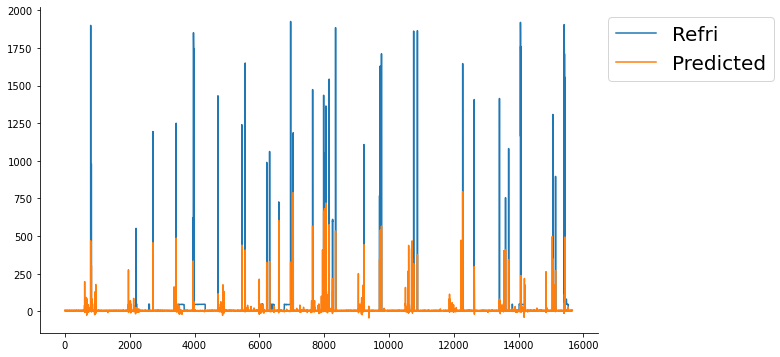

In [15]:
idx = xt.shape[0]
plt.figure(figsize=(10,6))
plt.plot(jnp.arange(idx), yt[:idx], label = "Refri")
plt.plot(jnp.arange(idx), y_mean[:idx], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
sns.despine()
plt.savefig("./Results/Microwave_Building2.png", bbox_inches="tight")

In [ ]:
# pred_dist_train = model.predict(x.to("cuda"))
# # print("Done ", i)

# y_mean_train = pred_dist_train.loc